# Hackathon Oil&Gas: Data Warehouse

## Participants
- Cindy Ortega - cindy.or03@gmail.com
- Nicolás Bueno - nbuenoz@unal.edu.co
- Alejandro Uribe - jduriber@unal.edu.co

## Libraries

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import downloadData
from utils import dataProc
from utils import generateWeb
from utils import generateDB
from pathlib import Path
from IPython.core.display import display, HTML
import qgrid

## Downloading, Loading & Cleanning Data

In [3]:
# Scrappes and downloads the data from ANH website
#download = downloadData.downloadData()
#download.getData()
data = dataProc.dataProc()
df = data.loadData()
df_dict = data.cleanData(df)
#Load Blind test data and Data
#data = dataProc.dataProc()
#df = data.loadData()
#df_dict_blind = data.loadBlindData()
#df_dict = data.cleanData(df)

Loading data
Loading data finished
Cleanning data
Cleaning data finsihed


## Database
The data can be also read from a SQLite Database as follows.

In [4]:
db_dir=Path('./database/anh_data.db')
conn = sqlite3.connect(db_dir)
c = conn.cursor()

The tables' names stored in the database can be retrieved as follows:

In [5]:
c.execute('''SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%';''').fetchall()

[('crude_2017',),
 ('crude_2016',),
 ('crude_2013',),
 ('crude_2019',),
 ('crude_2015',),
 ('crude_2014',),
 ('crude_2018',),
 ('crude_2020',)]

The `crude_2018` table's headers ca be retrieved as follows:

In [ ]:
c.execute('''PRAGMA table_info(crude_2019)''').fetchall()

Other queries are shown below:

In [ ]:
c.execute('''SELECT * FROM crude_2018 LIMIT 1''').fetchall()

For example, the top 5 departamentos which produced crude in January 2018.

In [ ]:
c.execute('''SELECT departamento, SUM(enero) AS total FROM crude_2018 GROUP BY crude_2018.departamento 
                ORDER BY total DESC LIMIT 5''').fetchall()

## Datasets 

In [6]:
widget_2020= qgrid.show_grid(df_dict['2020'],show_toolbar=True)
widget_2019= qgrid.show_grid(df_dict['2019'],show_toolbar=True)
widget_2018= qgrid.show_grid(df_dict['2018'],show_toolbar=True)

In [12]:
#Unfold, uncomment and run one of the following queries to watch the dataset you want
#widget_2020
#widget_2019
#widget_2018

## Data Analysis

In [3]:
#Function to display datasets side by side to save vertical space
#Input: dataframes and tables(dfs) titles

def dpy_side_by_side(dfs:list, titles:list):
    
    output = ""
    combined = dict(zip(titles, dfs))
    for title, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(title)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [4]:
#Identify null values in the datasets
dpy_side_by_side([df_dict['2018'].isnull().sum().to_frame(), df_dict['2019'].isnull().sum().to_frame(), df_dict['2020'].isnull().sum().to_frame()],["2018","2019","2020"])

,0
0,
departamento,0
municipio,0
operadora,0
contrato,0
campo,0
enero,0
febrero,0
marzo,0
abril,0


In [5]:
#Delete duplicates if there's any
df_dict['2018']=df_dict['2018'].drop_duplicates()
df_dict['2019']=df_dict['2019'].drop_duplicates()
df_dict['2020']=df_dict['2020'].drop_duplicates()

### Top 5 fields with the highest production in 2020

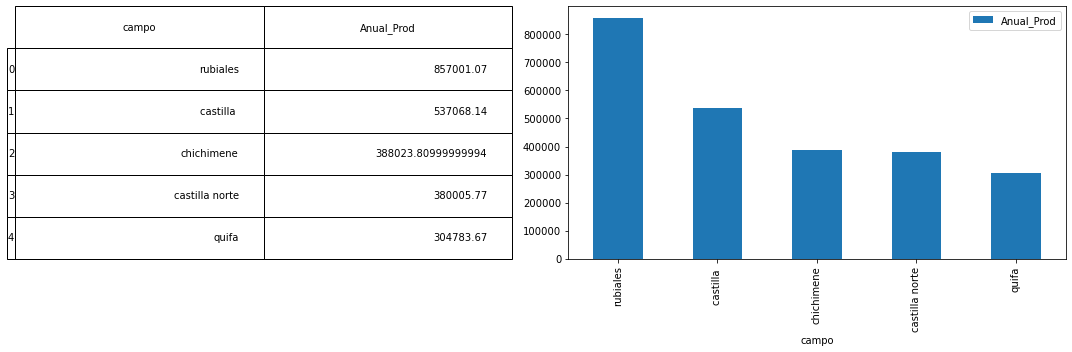

In [6]:
#Get location of january in the dataset 
January= df_dict['2020'].columns.get_loc("enero")

#Get total production by row
df_dict['2020']['Total_Prod']=df_dict['2020'].iloc[:,January::].fillna(0).sum(axis=1)

#Production 2020 by field
Prod_2020=df_dict['2020'].groupby('campo')['Total_Prod'].sum().reset_index(name ='Anual_Prod')
#Top 5 anual production by field
Highest_Prod=Prod_2020.sort_values(by=['Anual_Prod'], ascending=False).iloc[0:5,:].reset_index(drop=True)

#Visualization
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
font_size=10
bbox=[0, 0, 1, 1]

#table visualization
mpl_table = ax1.table(cellText = Highest_Prod.values, rowLabels = Highest_Prod.index, bbox=bbox, colLabels=Highest_Prod.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

#bar plot visualization
ax1.axis('off')
font_size=14
Highest_Prod.plot(x='campo', y='Anual_Prod', kind="bar",figsize=(15,5), ax=ax2)
fig.tight_layout()  


### Companies that have reported production in more than 5 fields in Casanare in 2018

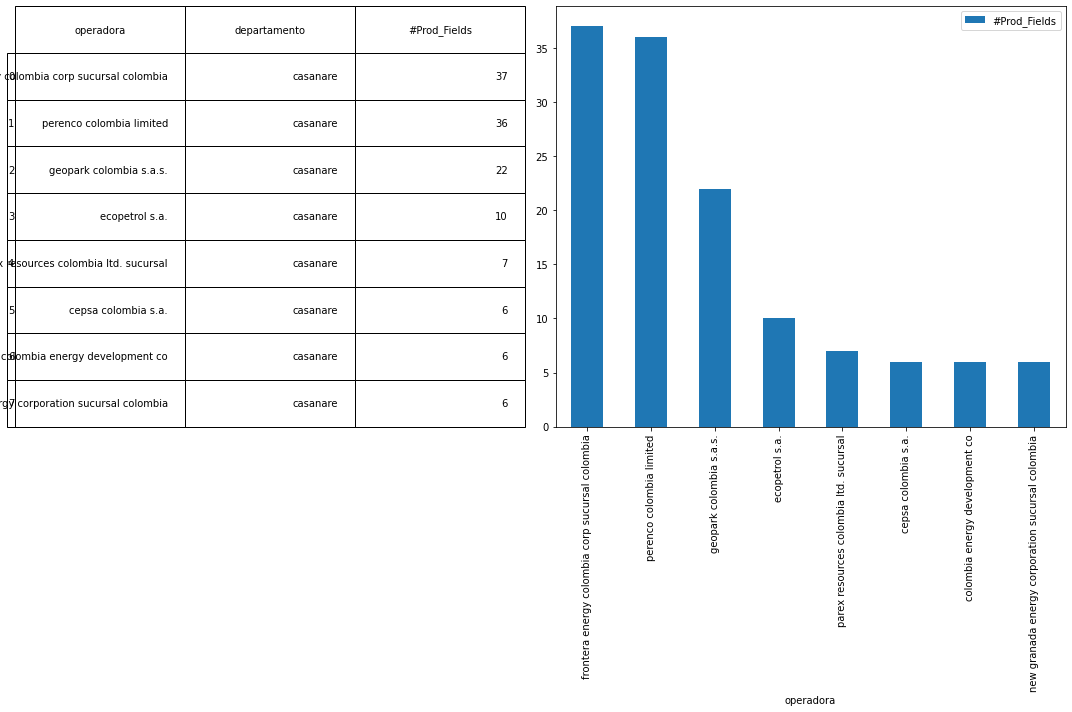

In [7]:
#Total production in 2018
Jan_2018= df_dict['2018'].columns.get_loc("enero")
df_dict['2018']['Total_Prod']=df_dict['2018'].iloc[:,Jan_2018::].fillna(0).sum(axis=1)

#Number of fields by companies
Op_Field_2018=df_dict['2018'][df_dict['2018']['Total_Prod']!=0]


Op_Field_2018=df_dict['2018'].groupby(['operadora','departamento'])['campo'].count().reset_index(name ='#Prod_Fields')
Op_casanare_2018=Op_Field_2018[(Op_Field_2018['departamento']=='casanare')&(Op_Field_2018['#Prod_Fields']>5)]
casanare_2018=Op_casanare_2018.sort_values(by=['#Prod_Fields'], ascending=False).reset_index(drop=True)

#Visualization
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,8))  # 1 row, 2 columns
font_size=10

#table visualization
mpl_table = ax1.table(cellText = casanare_2018.values, rowLabels = casanare_2018.index, bbox=bbox, colLabels=casanare_2018.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

#bar plot visualization
ax1.axis('off')
font_size=10
casanare_2018.plot(x='operadora', y='#Prod_Fields', kind="bar",figsize=(15,10), ax=ax2)
fig.tight_layout() 

### Top 5 contracts with the highest production in 2018

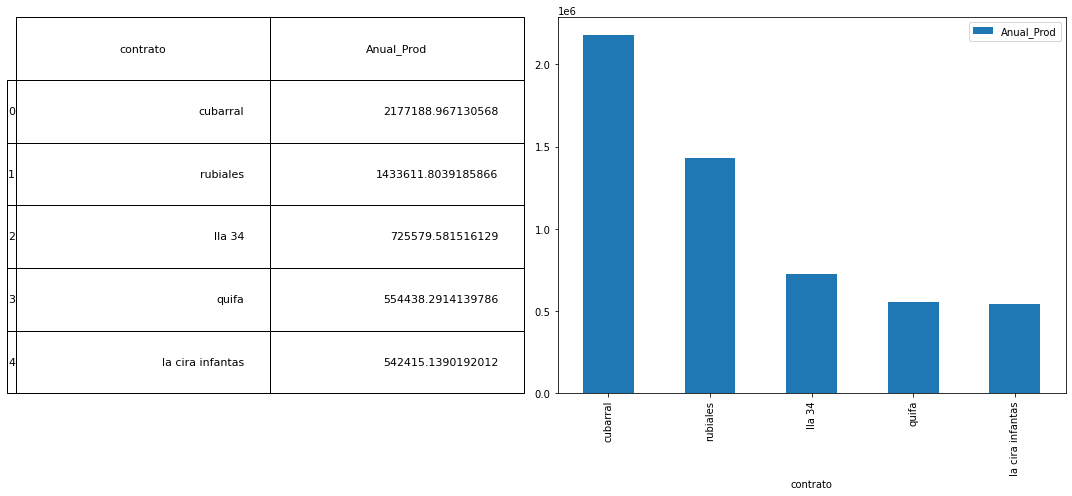

In [8]:
#Get production by contracts 
Cont_Highest_Prod= df_dict['2018'].groupby('contrato')['Total_Prod'].sum().reset_index(name ='Anual_Prod')
#Get top 5 contracts with the highest production
Five_Hg_prod=Cont_Highest_Prod.sort_values(by=['Anual_Prod'], ascending=False).iloc[0:5].reset_index(drop=True)

#Visualization
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
bbox=[0, 0, 1, 1]

#table visualization
font_size=11
mpl_table = ax1.table(cellText = Five_Hg_prod.values, rowLabels = Five_Hg_prod.index, bbox=bbox, colLabels=Five_Hg_prod.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

#bar plot visualization
ax1.axis('off')
font_size=11
Five_Hg_prod.plot(x='contrato', y='Anual_Prod', kind="bar",figsize=(15,7), ax=ax2)
fig.tight_layout()  

### Top 10 companies with the highest production in August 2019

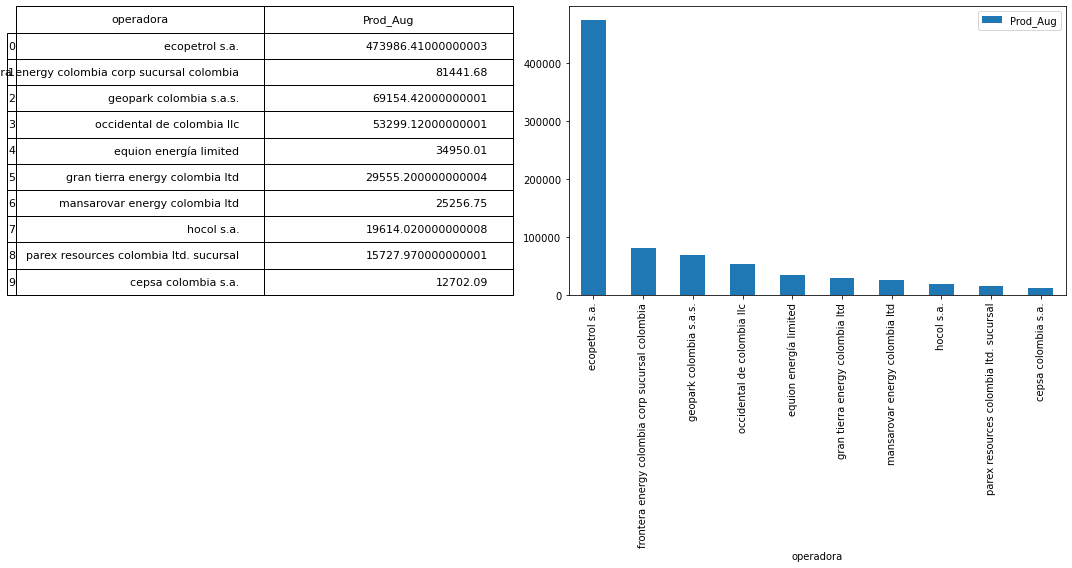

In [9]:
#Get production by company
Op_High_Prod_2019= df_dict['2019'].groupby('operadora')['agosto'].sum().reset_index(name ='Prod_Aug')
#Get top 10 companies with the highest production in Aug. 
Op_Hg_Pd_2019=Op_High_Prod_2019.sort_values(by=['Prod_Aug'], ascending=False).iloc[0:10].reset_index(drop=True)

#Visualization
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,10))  # 1 row, 2 columns
bbox=[0, 0, 1, 1]

#table visualization
font_size=11
mpl_table = ax1.table(cellText = Op_Hg_Pd_2019.values, rowLabels = Op_Hg_Pd_2019.index, bbox=bbox, colLabels=Op_Hg_Pd_2019.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

#bar plot visualization
ax1.axis('off')
font_size=11
Op_Hg_Pd_2019.plot(x='operadora', y='Prod_Aug', kind="bar",figsize=(15,8), ax=ax2)
fig.tight_layout() 

### <center> Comparative Analysis </center> 

In [10]:
#Get first quarter information
Tri_one_2019= df_dict['2019'].iloc[:,0:8]
Tri_one_2019= Tri_one_2019.copy()
Tri_one_2020= df_dict['2020'].iloc[:,0:8]
Tri_one_2020=Tri_one_2020.copy()
#total production by field 1st quarter
Tri_one_2019['total']= Tri_one_2019.iloc[:,5::].sum(axis=1)
Tri_one_2020['total']= Tri_one_2020.iloc[:,5::].sum(axis=1)

#Get second quarter information
Tri_two_2019= pd.concat([df_dict['2019'].iloc[:,0:5], df_dict['2019'].iloc[:,8:11]], axis=1)
Tri_two_2019=Tri_two_2019.copy()
Tri_two_2020= pd.concat([df_dict['2020'].iloc[:,0:5], df_dict['2020'].iloc[:,8:11]], axis=1)
Tri_two_2020=Tri_two_2020.copy()
#total production by field 2nd quarter
Tri_two_2019['total']= Tri_two_2019.iloc[:,5::].sum(axis=1)
Tri_two_2020['total']= Tri_two_2020.iloc[:,5::].sum(axis=1)

In [11]:
#Display the null values in the datasets
dpy_side_by_side([Tri_one_2019.isnull().sum().to_frame(),Tri_one_2020.isnull().sum().to_frame(),Tri_two_2019.isnull().sum().to_frame(),Tri_two_2020.isnull().sum().to_frame() ],
                 ['Null 1st Tri 2019','Null 1st Tri 2020','Null 2nd Tri 2019','Null 2nd Tri 2020'])

,0
0,
departamento,0
municipio,0
operadora,0
contrato,0
campo,0
enero,0
febrero,0
marzo,0
total,0


In [12]:
#Display the max, min, mean, std, Q1, Q2 an Q3 of the total production 
dpy_side_by_side([Tri_one_2019.describe(), Tri_two_2019.describe(), Tri_one_2020.describe(),  
                  Tri_two_2020.describe()],['Prod 1st Tri 2019','Prod 2nd Tri 2019','Prod 1st Tri 2020','Prod 2nd Tri 2020'])

0,total
count,456.000000
mean,5869.601820
std,24304.195939
min,0.000000
25%,160.915000
50%,747.445000
75%,3030.895000
max,361662.800000
0,total
count,456.000000


In [13]:
#Display the number of fields with zero production in the quarter
P0_2019_1=Tri_one_2019[Tri_one_2019['total']==0].count().to_frame()
P0_2020_1=Tri_one_2020[Tri_one_2020['total']==0].count().to_frame()
P0_2019_2=Tri_two_2019[Tri_two_2019['total']==0].count().to_frame()
P0_2020_2=Tri_two_2020[Tri_two_2019['total']==0].count().to_frame()

dpy_side_by_side([P0_2019_1,P0_2019_2,P0_2020_1,P0_2020_2],
                 ['# Fields Prod=0 1st Tri 2019','# Fields Prod=0 2nd Tri 2019','# Fields Prod=0 1st Tri 2020',
                  '# Fields Prod=0 2nd Tri 2020'])

<ipython-input-13-717b00641619>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  P0_2020_2=Tri_two_2020[Tri_two_2019['total']==0].count().to_frame()


,0
0,
departamento,42
municipio,42
operadora,42
contrato,42
campo,42
enero,42
febrero,42
marzo,42
total,42


Based on the description results and without further analysis, we could hypothesize that the current COVID-19 crisis affected the production since the maximum production went from approximately 361662 in 2019 to 303165 in 2020, as well as the mean production (from 5869 to 5468). The previous results have shown that even though in the description we can see a reduction in the fields from 2019 to 2020, those fields in 2019 were actually non-productive ones. As we can visualize, in 2019 there were 42 to 44 non-productive fields in the first and second quarters. On the other hand, you can see a recovery in the first quarter of 2020, and then relapse in the second quarter of the same year.

,campo,Prod_field
0,rubiales,361662.800000
1,castilla,216521.040000
2,chichimene,150331.410000
3,quifa,136077.150000
4,castilla norte,130026.150000
5,la cira,92201.990000
6,pauto sur,82989.460000
7,jacana,74300.770000
8,caño limón,68446.020000
9,acordionero,61961.950000


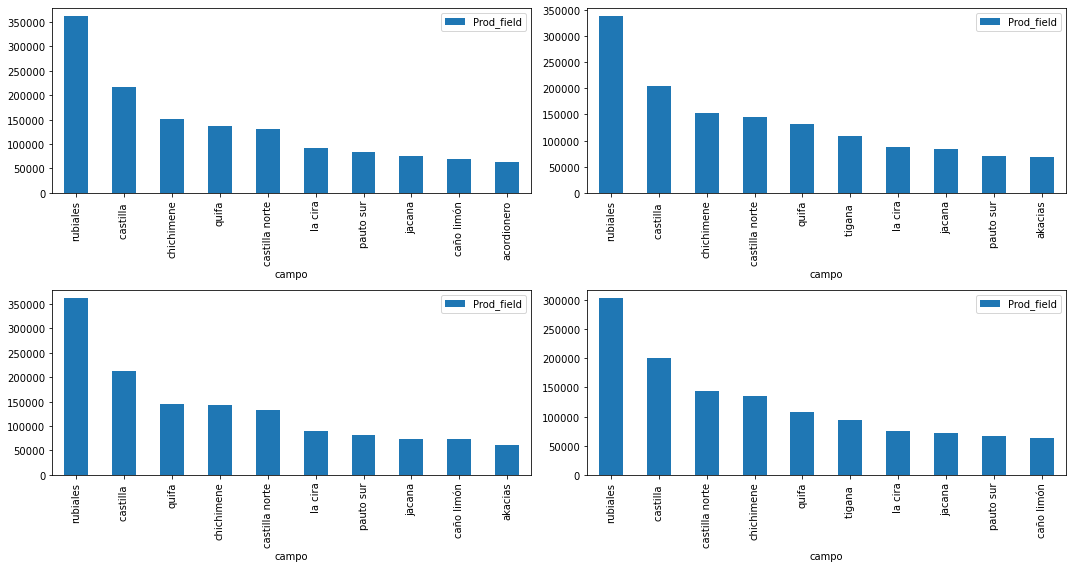

In [14]:
#Display Top 10 fields with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest values during the first two quarters of 2019 and 2020
Top10field_2019_1= Tri_one_2019.groupby('campo')['total'].sum().reset_index(name ='Prod_field').sort_values(by=['Prod_field'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10field_2019_2=Tri_one_2020.groupby('campo')['total'].sum().reset_index(name ='Prod_field').sort_values(by=['Prod_field'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10field_2020_1=Tri_two_2019.groupby('campo')['total'].sum().reset_index(name ='Prod_field').sort_values(by=['Prod_field'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10field_2020_2=Tri_two_2020.groupby('campo')['total'].sum().reset_index(name ='Prod_field').sort_values(by=['Prod_field'], ascending=False).iloc[0:10].reset_index(drop=True)

#call function to display results 
dpy_side_by_side([Top10field_2019_1,Top10field_2019_2,Top10field_2020_1,Top10field_2020_2],
                 ['Top Fields 1st Tri 2019','Top Fields 2nd Tri 2019','Top Fields 1st Tri 2020',
                  'Top Fields 2nd Tri 2020'])

#visualization
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))  # 1 row, 2 columns
font_size=11
Top10field_2019_1.plot(x='campo', y='Prod_field', kind="bar",figsize=(15,8), ax=ax1)
Top10field_2019_2.plot(x='campo', y='Prod_field', kind="bar",figsize=(15,8), ax=ax2)
Top10field_2020_1.plot(x='campo', y='Prod_field', kind="bar",figsize=(15,8), ax=ax3)
Top10field_2020_2.plot(x='campo', y='Prod_field', kind="bar",figsize=(15,8), ax=ax4)
fig.tight_layout() 

,departamento,Prod_dpto
0,meta,1331920.130000
1,casanare,521780.660000
2,santander,183903.810000
3,arauca,162828.550000
4,boyaca,98507.510000
5,putumayo,87649.000000
6,cesar,74442.430000
7,huila,71197.980000
8,antioquia,47367.510000
9,tolima,39952.570000


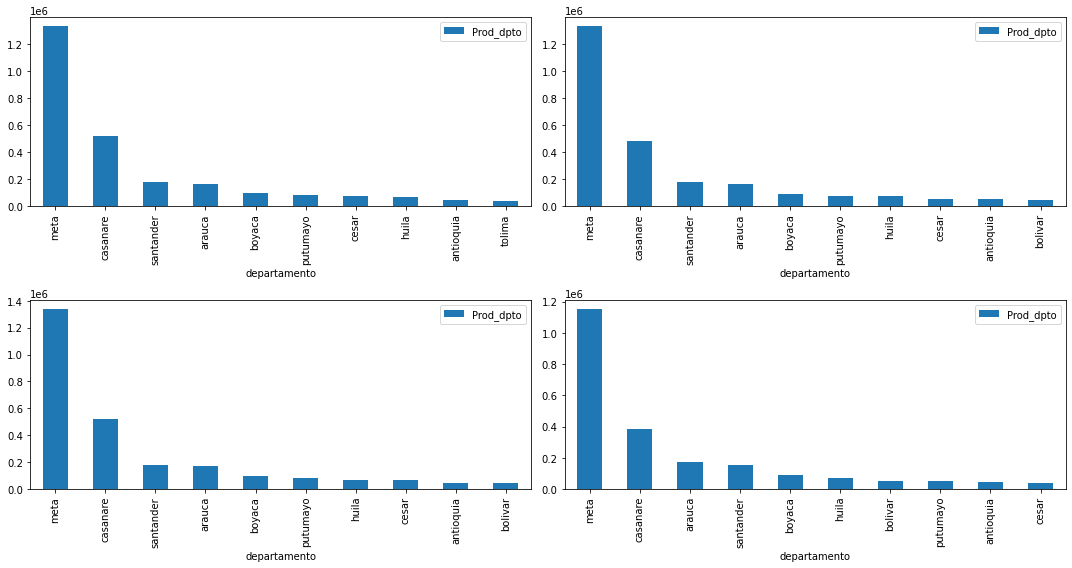

In [15]:
#Display Top 10 regions with the with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest values during the first two quarters of 2019 and 2020
Top10dto_2019_1= Tri_one_2019.groupby('departamento')['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10dto_2019_2=Tri_one_2020.groupby('departamento')['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10dto_2020_1=Tri_two_2019.groupby('departamento')['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10dto_2020_2=Tri_two_2020.groupby('departamento')['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)

#Call funcion to display results
dpy_side_by_side([Top10dto_2019_1,Top10dto_2019_2,Top10dto_2020_1,Top10dto_2020_2],
                 ['Top dpto prod 1st Tri 2019','Top dpto prod 2nd Tri 2019','Top dpto prod 1st Tri 2020',
                  'Top dpto prod 2nd Tri 2020'])

#Visualization
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))  # 1 row, 2 columns
font_size=11
Top10dto_2019_1.plot(x='departamento', y='Prod_dpto', kind="bar",figsize=(15,8), ax=ax1)
Top10dto_2019_2.plot(x='departamento', y='Prod_dpto', kind="bar",figsize=(15,8), ax=ax2)
Top10dto_2020_1.plot(x='departamento', y='Prod_dpto', kind="bar",figsize=(15,8), ax=ax3)
Top10dto_2020_2.plot(x='departamento', y='Prod_dpto', kind="bar",figsize=(15,8), ax=ax4)
fig.tight_layout() 

In [16]:
#Display Top 10 fields by region with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest production during the first two quarters of 2019 and 2020
Top_DPtofield_2019_1= Tri_one_2019.groupby(['departamento','campo'])['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top_DPtofield_2019_2=Tri_one_2020.groupby(['departamento','campo'])['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top_DPtofield_2020_1=Tri_two_2019.groupby(['departamento','campo'])['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top_DPtofield_2020_2=Tri_two_2020.groupby(['departamento','campo'])['total'].sum().reset_index(name ='Prod_dpto').sort_values(by=['Prod_dpto'], ascending=False).iloc[0:10].reset_index(drop=True)

#Call function to display results 
dpy_side_by_side([Top_DPtofield_2019_1,Top_DPtofield_2019_2,Top_DPtofield_2020_1,Top_DPtofield_2020_2],
                 ['Top fields by dpto prod 1st Tri 2019','Top fields by dpto prod 2nd Tri 2019','Top fields by dpto prod 1st Tri 2020',
                  'Top fields by dpto prod 2nd Tri 2020']) 

,departamento,campo,Prod_dpto
0,meta,rubiales,361662.800000
1,meta,castilla,216521.040000
2,meta,chichimene,150331.410000
3,meta,quifa,136077.150000
4,meta,castilla norte,130026.150000
5,santander,la cira,92201.990000
6,casanare,pauto sur,82989.460000
7,casanare,jacana,74300.770000
8,arauca,caño limón,68446.020000
9,cesar,acordionero,61961.950000


In [17]:
#Display Top 10 towns with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest values during the first two quarters of 2019 and 2020
Top10mpio_2019_1= Tri_one_2019.groupby('municipio')['total'].sum().reset_index(name ='Prod_mpio').sort_values(by=['Prod_mpio'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10mpio_2019_2=Tri_one_2020.groupby('municipio')['total'].sum().reset_index(name ='Prod_mpio').sort_values(by=['Prod_mpio'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10mpio_2020_1=Tri_two_2019.groupby('municipio')['total'].sum().reset_index(name ='Prod_mpio').sort_values(by=['Prod_mpio'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10mpio_2020_2=Tri_two_2020.groupby('municipio')['total'].sum().reset_index(name ='Prod_mpio').sort_values(by=['Prod_mpio'], ascending=False).iloc[0:10].reset_index(drop=True)

#Call function to display results 
dpy_side_by_side([Top10mpio_2019_1,Top10mpio_2019_2,Top10mpio_2020_1,Top10mpio_2020_2],
                 ['Top town prod 1st Tri 2019','Top town prod 2nd Tri 2019','Top town prod 1st Tri 2020',
                  'Top town prod 2nd Tri 2020'])

,municipio,Prod_mpio
0,PUERTO GAITAN,602779.230000
1,ACACIAS,315082.800000
2,CASTILLA NUEVA,224084.530000
3,TAURAMENA,147243.440000
4,BARRANCABERMEJA,140628.220000
5,YOPAL,122111.290000
6,ARAUCA,97641.960000
7,PUERTO BOYACA,97311.270000
8,VILLA NUEVA,96418.200000
9,SAN MARTÍN,69574.080000


The department of Meta is one of the largest oil producer regions since it has the Rubiales, Castilla, Chichimene fields, among others, which are the fields with the highest production recorded in 2019 and 2020. The decrease in production in these fields is remarkable through the quarters, but it is not crucial for the survival of the fields, unlike fields like Volcanera in the department of Casanare, whose reduction in production was low from the second quarter of 2019 to 2020, and this reduction was crucial for the survival of the field as it finally reached 0% production in the second quarter of 2020.

The same situation persists with the following results: 

In [18]:
#Display Top 10 companies with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest values during the first two quarters of 2019 and 2020
Top10op_2019_1= Tri_one_2019.groupby('operadora')['total'].sum().reset_index(name ='Prod_Op').sort_values(by=['Prod_Op'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10op_2019_2=Tri_one_2020.groupby('operadora')['total'].sum().reset_index(name ='Prod_Op').sort_values(by=['Prod_Op'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10op_2020_1=Tri_two_2019.groupby('operadora')['total'].sum().reset_index(name ='Prod_Op').sort_values(by=['Prod_Op'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10op_2020_2=Tri_two_2020.groupby('operadora')['total'].sum().reset_index(name ='Prod_Op').sort_values(by=['Prod_Op'], ascending=False).iloc[0:10].reset_index(drop=True)

#Call function to display results 
dpy_side_by_side([Top10op_2019_1,Top10op_2019_2,Top10op_2020_1,Top10op_2020_2],
                 ['Top companies 1st Tri 2019','Top companies 2nd Tri 2019','Top companies 1st Tri 2020',
                  'Top companies 2nd Tri 2020'])

,operadora,Prod_Op
0,ecopetrol s.a.,1439767.070000
1,frontera energy colombia corp sucursal colombia,243057.070000
2,geopark colombia s.a.s.,208932.030000
3,occidental de colombia llc,154958.680000
4,equion energía limited,110433.900000
5,gran tierra energy colombia ltd,107092.500000
6,mansarovar energy colombia ltd,78254.360000
7,hocol s.a.,58335.910000
8,cepsa colombia s.a.,45187.880000
9,parex resources colombia ltd. sucursal,37092.910000


,contrato,Prod_ctto
0,cubarral,557110.080000
1,rubiales,361662.800000
2,lla 34,206632.740000
3,quifa,144415.040000
4,la cira infantas,129915.620000
5,piedemonte,108215.740000
6,magdalena medio,98785.140000
7,cravo norte,81299.680000
8,nare,68697.850000
9,midas,62096.600000


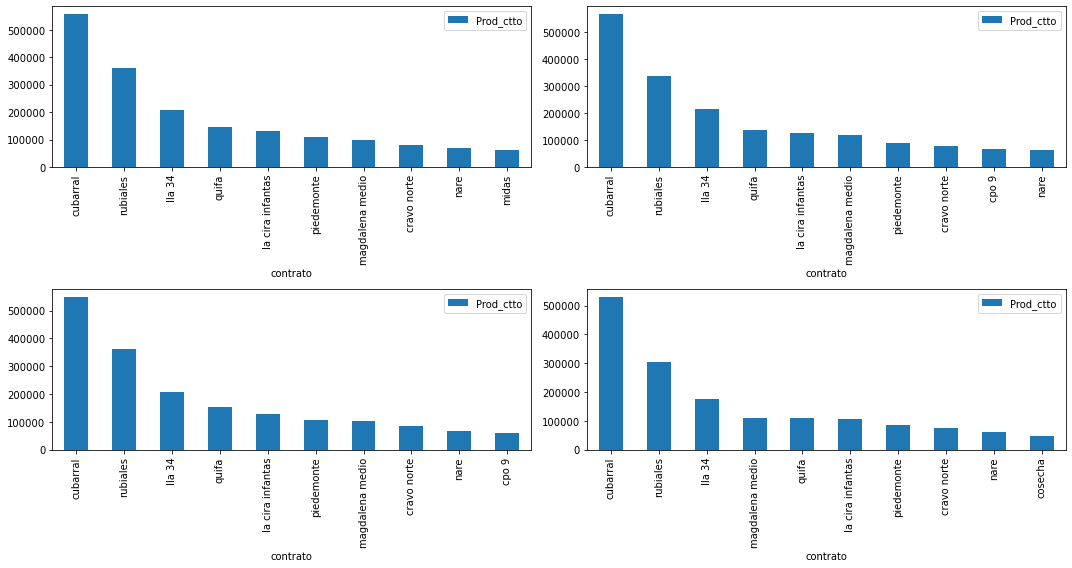

In [19]:
#Display Top 10 contracts with the highest production in the quarters 
#The iloc position can be switched to [-50:-1] to check the lowest values during the first two quarters of 2019 and 2020
Top10ctto_2019_1=Tri_one_2019.groupby('contrato')['total'].sum().reset_index(name ='Prod_ctto').sort_values(by=['Prod_ctto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10ctto_2019_2=Tri_one_2020.groupby('contrato')['total'].sum().reset_index(name ='Prod_ctto').sort_values(by=['Prod_ctto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10ctto_2020_1=Tri_two_2019.groupby('contrato')['total'].sum().reset_index(name ='Prod_ctto').sort_values(by=['Prod_ctto'], ascending=False).iloc[0:10].reset_index(drop=True)
Top10ctto_2020_2=Tri_two_2020.groupby('contrato')['total'].sum().reset_index(name ='Prod_ctto').sort_values(by=['Prod_ctto'], ascending=False).iloc[0:10].reset_index(drop=True)

dpy_side_by_side([Top10ctto_2019_1,Top10ctto_2019_2,Top10ctto_2020_1,Top10ctto_2020_2],
                 ['Top contracts 1st Tri 2019','Top contracts 2nd Tri 2019','Top contracts 1st Tri 2020',
                  'Top contracts 2nd Tri 2020'])

#Visualization
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))  # 1 row, 2 columns
font_size=11
Top10ctto_2019_1.plot(x='contrato', y='Prod_ctto', kind="bar",figsize=(15,8), ax=ax1)
Top10ctto_2019_2.plot(x='contrato', y='Prod_ctto', kind="bar",figsize=(15,8), ax=ax2)
Top10ctto_2020_1.plot(x='contrato', y='Prod_ctto', kind="bar",figsize=(15,8), ax=ax3)
Top10ctto_2020_2.plot(x='contrato', y='Prod_ctto', kind="bar",figsize=(15,8), ax=ax4)
fig.tight_layout() 